In [34]:
# from google.colab import drive
# drive.mount('/content/drive')

Import Brain MRI dataset

In [62]:
# import packages
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
#!pip install keras
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv3D, MaxPooling2D
from keras.preprocessing import image
%matplotlib inline
import nibabel as nib
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
from glob import glob
from skimage.io import imread
import skimage.transform as skTrans
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# Set
BASE_IMG_PATH=os.path.join(r'C:\Users\Kuro\Downloads\FL\task_quest')
#insert dataset
brainMRIData=pd.read_excel(r'C:\Users\Kuro\Downloads\FL\task_quest/Classification.xlsx')
# find class value

brainMRIData["Class"]=brainMRIData["Diagnosis"]>0
# set datatype
brainMRIData.Class = brainMRIData.Class.astype('int')
brainMRIDataCol=brainMRIData.columns

brainMRIData=brainMRIData.drop(['Diagnosis'], axis = 1)
brainMRIData

,ID_CF,First Episodes (FEP) / Healthy Control (HC),Class
0,CF_001,FEP,1
1,CF_002,FEP,1
2,CF_003,FEP,1
3,CF_004,FEP,1
4,CF_005,FEP,1
...,...,...,...
787,CF_921,HC,0
788,CF_922,HC,0
789,CF_923,HC,0
790,CF_924,HC,0


In [63]:
# perform path
brainMRIImages=glob(os.path.join(BASE_IMG_PATH,'normalized','wCF_*'))
print(len(brainMRIImages),' matching files found:',brainMRIImages[0])
# load images
imagesTest=nib.load(brainMRIImages[0])
imagesTest=imagesTest.get_fdata()
random.shuffle(imagesTest)
# for loop for load images
for myimages in imagesTest:
    fileName='w'+ brainMRIData['ID_CF']+'_MRI_sMRI_'+ brainMRIData['ID_CF']+'.nii.gz'  
    
    break

# print filenames
print(fileName)

761  matching files found: C:\Users\Kuro\Downloads\FL\task_quest\normalized\wCF_001_MRI_sMRI_CF_001.nii.gz
0      wCF_001_MRI_sMRI_CF_001.nii.gz
1      wCF_002_MRI_sMRI_CF_002.nii.gz
2      wCF_003_MRI_sMRI_CF_003.nii.gz
3      wCF_004_MRI_sMRI_CF_004.nii.gz
4      wCF_005_MRI_sMRI_CF_005.nii.gz
                    ...              
787    wCF_921_MRI_sMRI_CF_921.nii.gz
788    wCF_922_MRI_sMRI_CF_922.nii.gz
789    wCF_923_MRI_sMRI_CF_923.nii.gz
790    wCF_924_MRI_sMRI_CF_924.nii.gz
791    wCF_926_MRI_sMRI_CF_926.nii.gz
Name: ID_CF, Length: 792, dtype: object


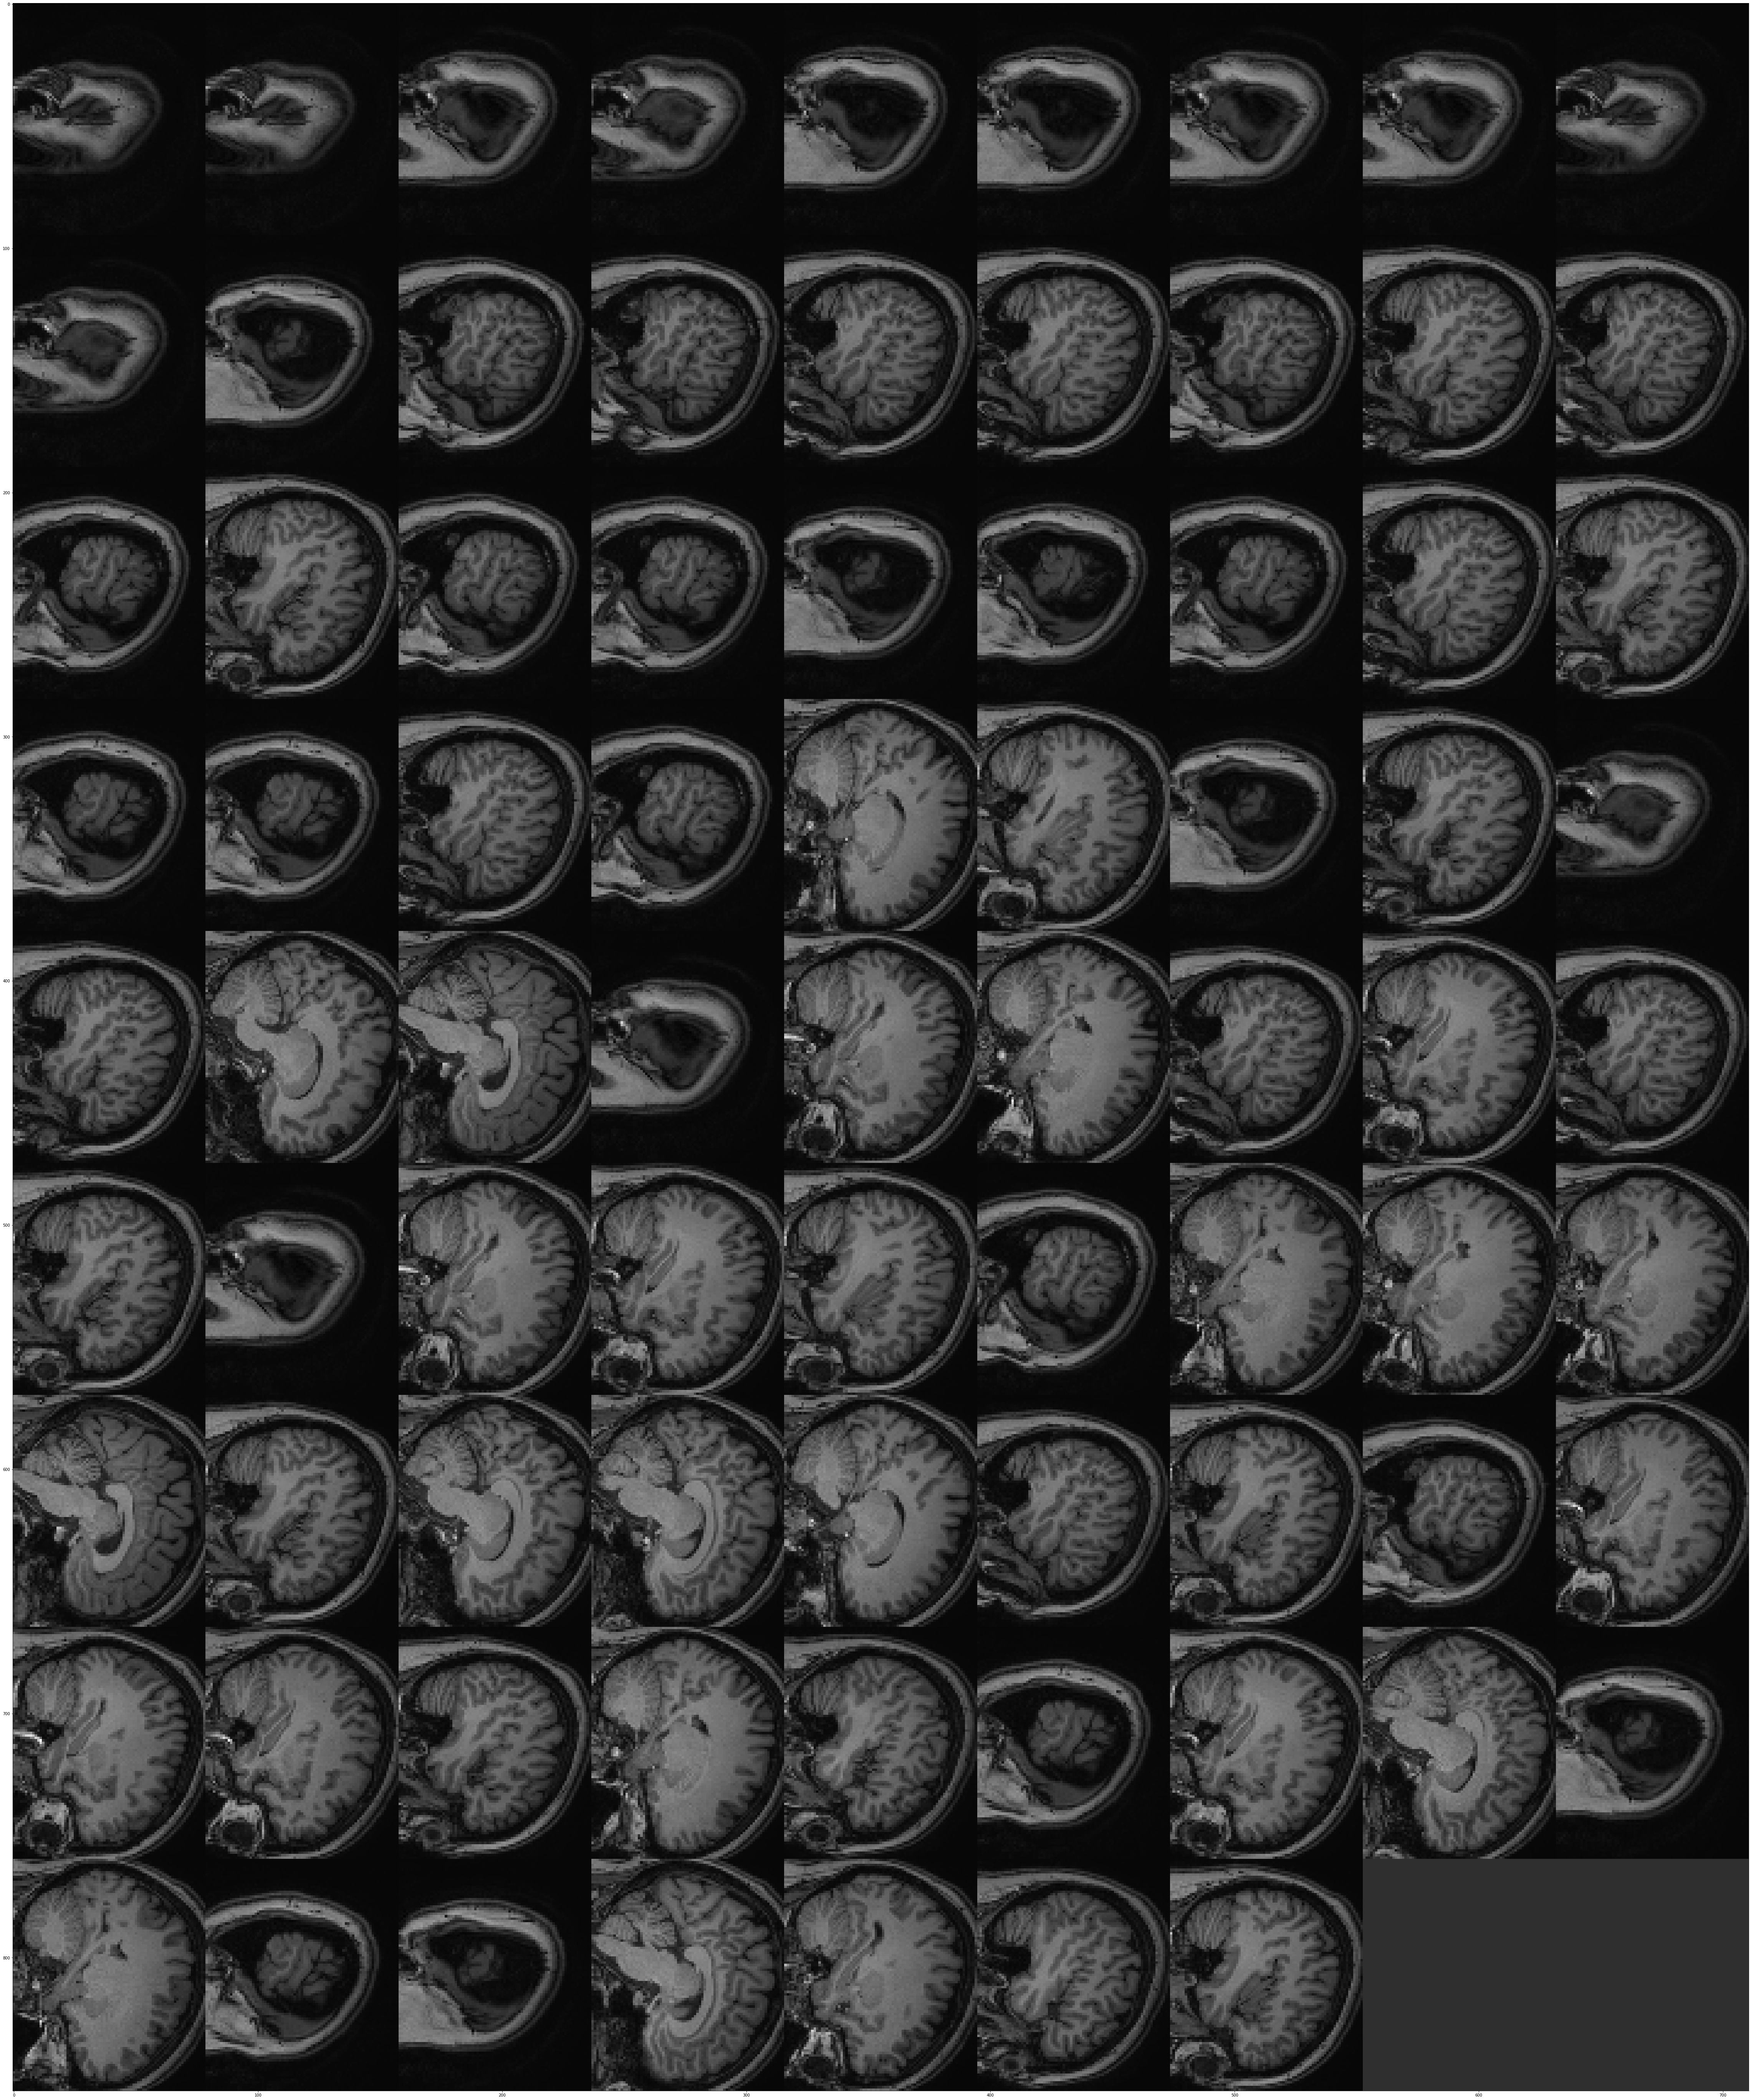

In [64]:
# EDA
from skimage.util import montage as montage2d
fig, showImg = plt.subplots(1, 1, figsize = (100, 100))
showImg.imshow(montage2d(imagesTest), cmap ='gray')



In [65]:
brainMRIData['ID_CF']

0      CF_001
1      CF_002
2      CF_003
3      CF_004
4      CF_005
        ...  
787    CF_921
788    CF_922
789    CF_923
790    CF_924
791    CF_926
Name: ID_CF, Length: 792, dtype: object

In [66]:
brainMRIImages

['C:\\Users\\Kuro\\Downloads\\FL\\task_quest\\normalized\\wCF_001_MRI_sMRI_CF_001.nii.gz',
 'C:\\Users\\Kuro\\Downloads\\FL\\task_quest\\normalized\\wCF_002_MRI_sMRI_CF_002.nii.gz',
 'C:\\Users\\Kuro\\Downloads\\FL\\task_quest\\normalized\\wCF_003_MRI_sMRI_CF_003.nii.gz',
 'C:\\Users\\Kuro\\Downloads\\FL\\task_quest\\normalized\\wCF_004_MRI_sMRI_CF_004.nii.gz',
 'C:\\Users\\Kuro\\Downloads\\FL\\task_quest\\normalized\\wCF_005_MRI_sMRI_CF_005.nii.gz',
 'C:\\Users\\Kuro\\Downloads\\FL\\task_quest\\normalized\\wCF_006_MRI_sMRI_CF_006.nii.gz',
 'C:\\Users\\Kuro\\Downloads\\FL\\task_quest\\normalized\\wCF_007_MRI_sMRI_CF_007.nii.gz',
 'C:\\Users\\Kuro\\Downloads\\FL\\task_quest\\normalized\\wCF_008_MRI_sMRI_CF_008.nii.gz',
 'C:\\Users\\Kuro\\Downloads\\FL\\task_quest\\normalized\\wCF_009_MRI_sMRI_CF_009.nii.gz',
 'C:\\Users\\Kuro\\Downloads\\FL\\task_quest\\normalized\\wCF_010_MRI_sMRI_CF_010.nii.gz',
 'C:\\Users\\Kuro\\Downloads\\FL\\task_quest\\normalized\\wCF_011_MRI_sMRI_CF_011.nii.gz',

In [67]:
brainMRIImages[5][brainMRIImages[5].rfind('CF'):-7]

'CF_006'

In [74]:
if not brainMRIData[brainMRIData['ID_CF'].str.contains('CF_006')].empty:
    print("dung roi")

In [111]:
from scipy import ndimage
def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 79
    desired_width = 95
    desired_height = 95
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img
def process_scan(volume):
    """Read and resize volume""" 
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [87]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self):  
        self.data = []
        for i in range(len(brainMRIImages)):
            mage_name = brainMRIImages[i][brainMRIImages[i].rfind('CF'):-7]
            if not brainMRIData[brainMRIData['ID_CF'].str.contains(image_name)].empty:        
                img=nib.load(brainMRIImages[i]).get_fdata()
                class_id = brainMRIData[brainMRIData['ID_CF'].str.contains(image_name)]['Class'].values[0]
                self.data.append([img, class_id])
        print(self.data)        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, class_id = self.data[idx]                
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [116]:
import torch
import skimage.transform as skTrans
# array
showImgArr = []
# import image
abnormal_scan = []
normal_scan = []
abnormal_class =  []
normal_class=[]
for i in range(len(brainMRIImages)):
#     try:
#         import nibabel as nib
#     except:
#         raise ImportError('Install NIBABEL')
#     print(i)
    image_name = brainMRIImages[i][brainMRIImages[i].rfind('CF'):-7]
#     print(brainMRIImages[i])
#     print(brainMRIData[brainMRIData['ID_CF'].str.contains(image_name)])
    if not brainMRIData[brainMRIData['ID_CF'].str.contains(image_name)].empty:        
        img=nib.load(brainMRIImages[i]).get_fdata()
        class_id = brainMRIData[brainMRIData['ID_CF'].str.contains(image_name)]['Class'].values[0]
        if class_id==1:
            abnormal_scan.append(img)
            abnormal_class.append(class_id)
        elif class_id==0:
            normal_scan.append(img)
            normal_class.append(class_id)
#         all_img.append(img)
#         all_class.append(class_id)
#         img_tensor = torch.from_numpy(img)
# #         img_tensor = img_tensor.permute(2, 0, 1)
#         class_id = torch.tensor([class_id])
        
#     imagesTest=imagesTest.get_fdata()
#     print(imagesTest)
#     # suffle images
#     random.shuffle(imagesTest)    
    
#     FigT= imagesTest/255
#     # append image
#     showImgArr.append(FigT)

# # set array value
# X = np.array(showImgArr)


In [117]:
abnormal_scans = np.array([process_scan(img) for img in abnormal_scan])
normal_scans = np.array([process_scan(img) for img in normal_scan])

In [118]:
abnormal_labels = np.array([1 for _ in range(len(abnormal_scan))])
normal_labels = np.array([0 for _ in range(len(normal_scan))])

In [123]:
print(len(abnormal_scans))
print(len(normal_scans))
print(len(abnormal_labels))
print(len(normal_labels))

227
455
227
455


In [132]:
x_train = np.concatenate((abnormal_scans[:5], normal_scans[:5]), axis=0)
y_train = np.concatenate((abnormal_labels[:5], normal_labels[:5]), axis=0)
x_val = np.concatenate((abnormal_scans[5:7], normal_scans[5:7]), axis=0)
y_val = np.concatenate((abnormal_labels[5:7], normal_labels[5:7]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 10 and 4.


In [ ]:
x_train = np.concatenate((abnormal_scans[:180], normal_scans[:350]), axis=0)
y_train = np.concatenate((abnormal_labels[:180], normal_labels[:350]), axis=0)
x_val = np.concatenate((abnormal_scans[180:], normal_scans[350:]), axis=0)
y_val = np.concatenate((abnormal_labels[180:], normal_labels[350:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

In [133]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [134]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (95, 95, 79, 1)


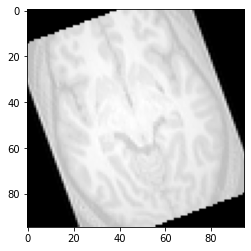

In [135]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")


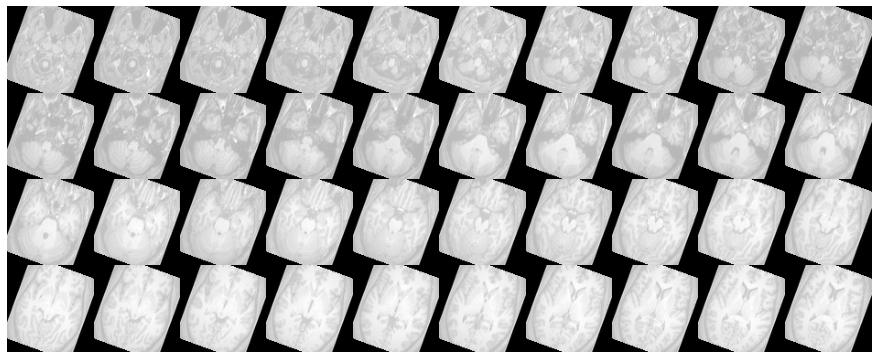

In [136]:

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 95, 95, image[:, :, :40])

In [137]:

def get_model(width=95, height=95, depth=79):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=95, height=95, depth=79)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 95, 95, 79, 1)]   0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 93, 93, 77, 64)    1792      
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 46, 46, 38, 64)    0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 46, 46, 38, 64)    256       
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 44, 44, 36, 64)    110656    
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 22, 22, 18, 64)    0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 22, 22, 18, 64)    256   

In [139]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 5
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=3,
    epochs=epochs,
    shuffle=True,
    verbose=1,
#     callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/5
1/5 [=====>........................] - ETA: 1:20 - loss: 0.8144 - acc: 0.5000

KeyboardInterrupt: 

In [92]:
nib.load(brainMRIImages[1]).get_fdata().shape

(79, 95, 79)

In [5]:
# find y value
y = np.array(brainMRIData.drop(['ID_CF', 'First Episodes (FEP) / Healthy Control (HC)'],axis=1))
y.shape
# split data
xTrainValue, xTestValue, yTrainValue, yTestValue = train_test_split(X, y, random_state=16, test_size=0.3)
xTrainValue


array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        

In [ ]:
yTrainValue.shape

(554, 1)

In [103]:
for i,sample in enumerate(data_loader):
    mr = sample[0].float().to('cpu')
    print('input sample shape of train_loader: {}'.format(mr.shape))
    break

input sample shape of train_loader: torch.Size([4, 79, 79, 95])


In [97]:

import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
def get_model(width=79, height=95, depth=79):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth,width, height,  1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=79, height=95, depth=79)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 79, 79, 95, 1)]   0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 77, 77, 93, 64)    1792      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 38, 38, 46, 64)    0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 38, 38, 46, 64)    256       
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 36, 36, 44, 64)    110656    
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 18, 18, 22, 64)    0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 18, 18, 22, 64)    256   

In [98]:
from keras.losses import categorical_crossentropy
#from keras.optimizers import Adadelta
import plotly.graph_objs as go
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from tensorflow.keras.utils import to_categorical
import h5py
import numpy as np
import matplotlib.pyplot as plt
initial_learning_rate = 0.0001
# Compile the model
model.compile(loss=tensorflow.keras.losses.binary_crossentropy,
                  optimizer=tensorflow.keras.optimizers.Adam(lr=initial_learning_rate),
                  metrics=['accuracy'])

c:\users\kuro\appdata\local\programs\python\python36\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
# fit CNNmodel
history=model.fit(xTrainValue, yTrainValue, epochs=10,validation_data=(xTestValue, yTestValue))


In [ ]:
# plot the accuracy and loss
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    # find accuracy
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    # find validation accuracy
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    # set title
    plt.title("train_acc vs val_accuracy")
    # set labels
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    # set legend
    plt.legend()

    # Plot loss 
    plt.subplot(222)
    # find loss value
    plt.plot(history.history['loss'],'bo--', label = "loss")
    # find validation loss value
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    # set labels and legend
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
# plot accuracy and loss
plot_accuracy_loss(history)

In [ ]:
loss, accuracy = model.evaluate(xTestValue, yTestValue, verbose=1)
loss_v, accuracy_v = model.evaluate(xTrainValue, yTrainValue, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))